<a href="https://colab.research.google.com/github/kuds/rl-lunar-lander/blob/main/%5BLunar%20Lander%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization (PPO)
---
In this notebook, you will implement a PPO agent with Gymansium's LunarLander-v3 environment.

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium[box2d]

In [3]:
import gymnasium
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.callbacks import CheckpointCallback, CallbackList

import os
import torch
import numpy
import scipy
import platform
import IPython
import matplotlib
import matplotlib.pyplot
from importlib.metadata import version

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
if torch.cuda.is_available(): print(f"GPU Device: {torch.cuda.get_device_name(0)}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.12.12
Torch Version: 2.8.0+cu126
Is Cuda Available: True
Cuda Version: 12.6
GPU Device: NVIDIA L4
Gymnasium Version: 1.2.1
Numpy Version: 2.0.2
Scipy Version: 1.16.2
Swig Version: 4.3.1.post0
Stable Baselines3 Version: 2.7.0
IPython Version: 7.34.0


In [5]:
rl_type = "PPO"
env_str = "LunarLander-v3"
log_dir = "./logs/{}/{}".format(env_str, rl_type)
name_prefix = "lunar_lander"

In [6]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to 

Observation Space Size:  (8,)
Actions Space:  Discrete(4)


In [7]:
# Create Training Environment
env = make_vec_env(env_str,
                   n_envs=1,
                   monitor_dir=os.path.join(log_dir, "monitor"))

# Create Evaluation Environment
env_val = make_vec_env(env_str, n_envs=1)

In [8]:
# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_freq = 25_000

eval_callback = EvalCallback(
    env_val,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=eval_freq,
    render=False,
    deterministic=True,
    n_eval_episodes=20)

checkpoint_callback = CheckpointCallback(
    save_freq=eval_freq,
    save_path=os.path.join(log_dir, "checkpoint")
)

# Create the callback list
callbackList = CallbackList([checkpoint_callback,
                             eval_callback])

In [9]:
# Initialize PPO
model = PPO('MlpPolicy',
            env,
            verbose=0,
            ent_coef=0.0075,
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

# Train the model
model.learn(total_timesteps=750_000,
            progress_bar=False,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Final Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Eval num_timesteps=25000, episode_reward=-481.91 +/- 224.63
Episode length: 196.25 +/- 83.23
New best mean reward!
Eval num_timesteps=50000, episode_reward=-222.96 +/- 68.42
Episode length: 403.20 +/- 124.43
New best mean reward!
Eval num_timesteps=75000, episode_reward=-220.20 +/- 59.47
Episode length: 463.40 +/- 157.94
New best mean reward!
Eval num_timesteps=100000, episode_reward=-113.02 +/- 111.09
Episode length: 604.90 +/- 228.76
New best mean reward!
Eval num_timesteps=125000, episode_reward=43.34 +/- 119.77
Episode length: 828.70 +/- 216.52
New best mean reward!
Eval num_timesteps=150000, episode_reward=58.48 +/- 98.52
Episode length: 858.25 +/- 140.60
New best mean reward!
Eval num_timesteps=175000, episode_reward=22.92 +/- 99.09
Episode length: 776.10 +/- 231.47
Eval num_timesteps=200000, episode_reward=126.60 +/- 102.50
Episode length: 693.75 +/- 185.81
New best mean reward!
Eval num_timesteps=225000, episode_reward=69.00 +/- 142.92
Episode length: 579.45 +/- 238.64
Eval num

In [10]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env,
                       log_dir,
                       video_length=5_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

obs = env.reset()
for _ in range(5_000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: 220.66 +/- 93.99
Moviepy - Building video /content/logs/LunarLander-v3/PPO/best_model_lunar_lander-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/logs/LunarLander-v3/PPO/best_model_lunar_lander-step-0-to-step-5000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/logs/LunarLander-v3/PPO/best_model_lunar_lander-step-0-to-step-5000.mp4


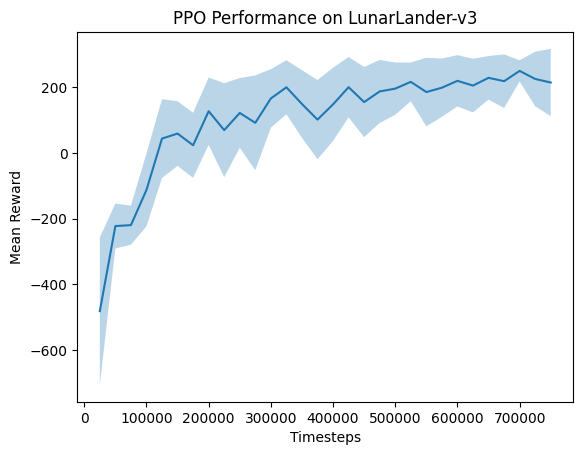

In [11]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.savefig(os.path.join(log_dir, f"{rl_type}_{env_str}_performance.png"))
matplotlib.pyplot.show()

In [12]:
rl_type = "PPO"
env_str = "LunarLanderContinuous-v3"
log_dir = "./logs/{}/{}".format(env_str, rl_type)
name_prefix = "lunar_lander_continuous"

In [13]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (8,)
Action Space Size:  (2,)


In [14]:
# Create Training Environment
env = make_vec_env(env_str,
                   n_envs=1,
                   monitor_dir=os.path.join(log_dir, "monitor"))

# Create Evaluation Environment
env_val = make_vec_env(env_str, n_envs=1)

In [15]:
# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_freq = 25_000

eval_callback = EvalCallback(
    env_val,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=eval_freq,
    render=False,
    deterministic=True,
    n_eval_episodes=20)

checkpoint_callback = CheckpointCallback(
    save_freq=eval_freq,
    save_path=os.path.join(log_dir, "checkpoint")
)

# Create the callback list
callbackList = CallbackList([checkpoint_callback,
                             eval_callback])

In [16]:
# Initialize PPO
model = PPO('MlpPolicy',
            env,
            verbose=0,
            ent_coef=0.0075,
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

# Train the model
model.learn(total_timesteps=750_000,
            progress_bar=False,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Final Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=-237.45 +/- 57.18
Episode length: 140.55 +/- 36.61
New best mean reward!
Eval num_timesteps=50000, episode_reward=-179.32 +/- 60.74
Episode length: 735.50 +/- 260.04
New best mean reward!
Eval num_timesteps=75000, episode_reward=-29.67 +/- 24.88
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=138.40 +/- 77.54
Episode length: 801.25 +/- 73.85
New best mean reward!
Eval num_timesteps=125000, episode_reward=149.12 +/- 62.22
Episode length: 653.35 +/- 98.55
New best mean reward!
Eval num_timesteps=150000, episode_reward=177.70 +/- 88.15
Episode length: 484.35 +/- 86.30
New best mean reward!
Eval num_timesteps=175000, episode_reward=146.14 +/- 97.96
Episode length: 459.00 +/- 76.12
Eval num_timesteps=200000, episode_reward=124.05 +/- 110.50
Episode length: 415.60 +/- 80.56
Eval num_timesteps=225000, episode_reward=28.75 +/- 143.04
Episode length: 457.80 +/- 67.64
Eval num_timesteps=250000, episode_rewa

In [17]:
# Create Elevation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Lunar Lander
best_model_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env,
                       log_dir,
                       video_length=5000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=best_model_file_name)

obs = env.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
      break

env.close()

Best Model - Mean reward: 214.55 +/- 67.09
Moviepy - Building video /content/logs/LunarLanderContinuous-v3/PPO/best_model_lunar_lander_continuous-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/logs/LunarLanderContinuous-v3/PPO/best_model_lunar_lander_continuous-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/LunarLanderContinuous-v3/PPO/best_model_lunar_lander_continuous-step-0-to-step-5000.mp4


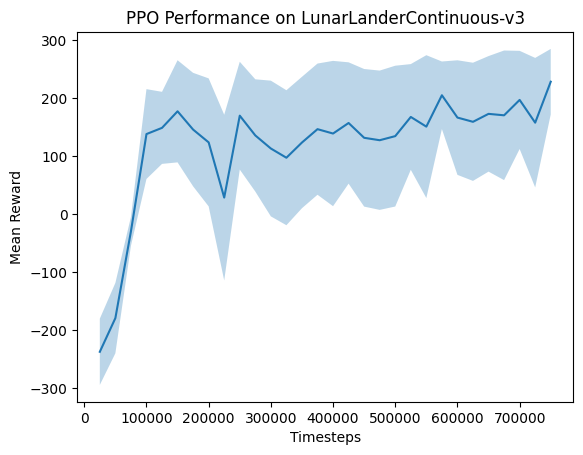

In [18]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.savefig(os.path.join(log_dir, f"{rl_type}_{env_str}_performance.png"))
matplotlib.pyplot.show()